In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [15]:
def getData():
    data = pd.read_csv("~/Desktop/NCSA_genomics/onePersonData.txt", sep="\t")
    data.head()
    #df["Display Time"]
    return data

In [47]:
df = getData()
df.head()
#df.shape


,Display Time,GlucoseValue,subjectId,Internal Time
0,2014-02-03 03:42:12,93.0,1636-69-001,2016-02-03 00:05:23
1,2014-02-03 03:47:12,93.0,1636-69-001,2016-02-03 00:10:23
2,2014-02-03 03:52:12,93.0,1636-69-001,2016-02-03 00:15:23
3,2014-02-03 03:57:12,95.0,1636-69-001,2016-02-03 00:20:23
4,2014-02-03 04:02:12,96.0,1636-69-001,2016-02-03 00:25:23


In [48]:
tf.random.set_seed(1234)
TRAIN_SPLIT = 1500


In [49]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [50]:
uni_data = df['GlucoseValue']
uni_data.index = df['Display Time']
uni_data.head()

Display Time
2014-02-03 03:42:12    93.0
2014-02-03 03:47:12    93.0
2014-02-03 03:52:12    93.0
2014-02-03 03:57:12    95.0
2014-02-03 04:02:12    96.0
Name: GlucoseValue, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1426d9a50>],
      dtype=object)

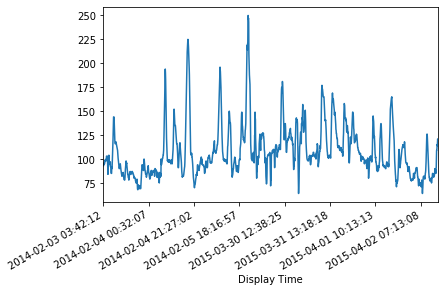

In [51]:
uni_data.plot(subplots=True)

In [52]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [53]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [54]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.6467603 ]
 [-0.6467603 ]
 [-0.6467603 ]
 [-0.5752503 ]
 [-0.5394953 ]
 [-0.5752503 ]
 [-0.5752503 ]
 [-0.5752503 ]
 [-0.5394953 ]
 [-0.5037403 ]
 [-0.43223029]
 [-0.43223029]
 [-0.46798529]
 [-0.43223029]
 [-0.46798529]
 [-0.46798529]
 [-0.39647529]
 [-0.39647529]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.5037403 ]
 [-0.82553531]
 [-0.96855531]
 [-0.78978031]
 [-0.5394953 ]
 [-0.5394953 ]]

 Target temperature to predict
-0.3607202906082465


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

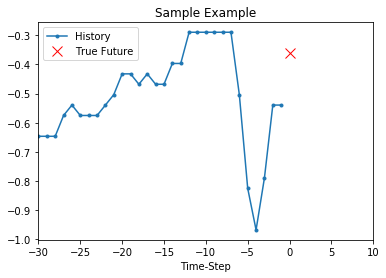

In [55]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [56]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [57]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [58]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [59]:
EVALUATION_INTERVAL = 1500
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=300)

Train for 1500 steps, validate for 300 steps
Epoch 1/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.1578 - val_loss: nan
Epoch 2/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.0775 - val_loss: nan
Epoch 3/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0757 - val_loss: nan
Epoch 4/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0749 - val_loss: nan
Epoch 5/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0745 - val_loss: nan
Epoch 6/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0742 - val_loss: nan
Epoch 7/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0740 - val_loss: nan
Epoch 8/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0736 - val_loss: nan
Epoch 9/10
1500/1500 [==============================] - 38s 25ms/step - loss: 0.0733 - val_loss: nan
Epoch 10/10
1500/1500 [=======================

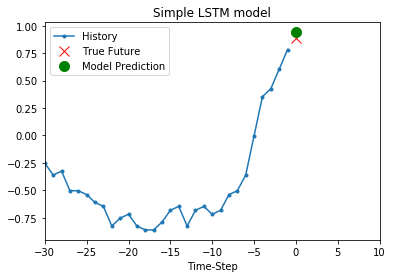

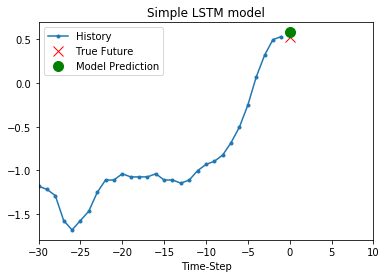

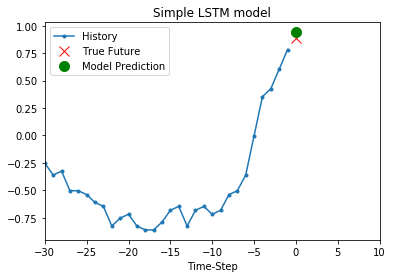

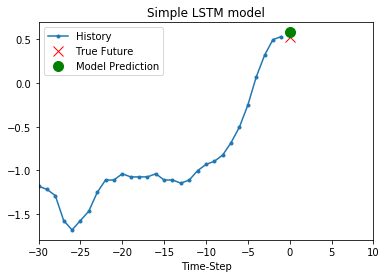

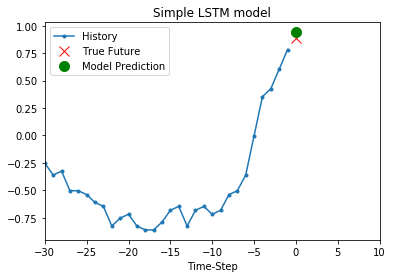

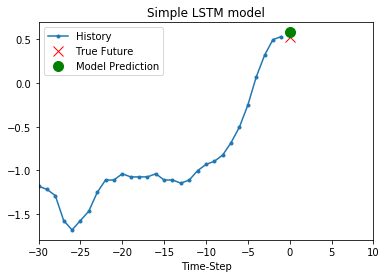

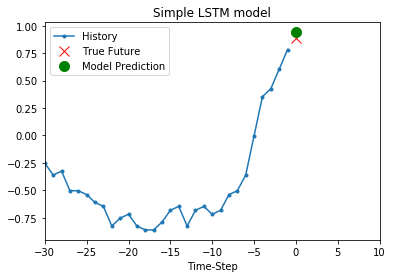

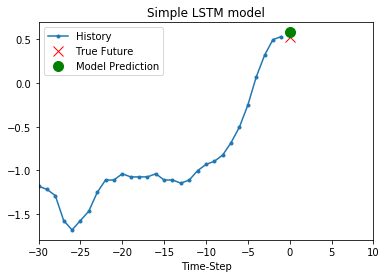

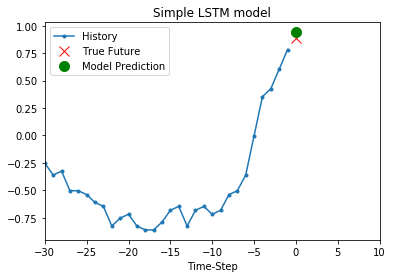

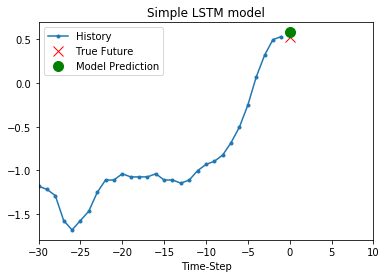

In [62]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()